In [1]:
!git clone https://github.com/william-dan/rl-elevator.git
%cd rl-elevator
!pip install -e .

Cloning into 'rl-elevator'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 97 (delta 40), reused 84 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 140.45 KiB | 28.09 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/rl-elevator
Obtaining file:///content/rl-elevator
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 35.8 MB/s eta 0:00:00
  Building editable for Elevato

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(123)

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)
def action_flatten_to_matrix(action, num_floors, num_cars):
    return (action % (num_floors+1), action // (num_floors+1))

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_dim_size):
        super(PolicyNetwork, self).__init__()
        # 3 fully connected layers
        self.linear1 = nn.Linear(n_inputs, hidden_dim_size)
        self.linear2 = nn.Linear(hidden_dim_size, n_outputs)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        # instead of returning one output, let's return logπ together with π
        probs = F.softmax(self.linear2(x), dim=-1)
        log_probs = torch.log(probs)

        return probs, log_probs


# TODO: Implement the value network
class ValueNetwork(nn.Module):
    def __init__(self, num_states, hidden_dim):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(num_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        return self.linear2(x)

In [6]:
import Elevators
N = 20
M = 4

# passenger_rate = 0.3
env = gym.make("Elevators/Elevators-v0",
               num_floors=N,
               num_cars=M,
               avg_passengers_spawning_time=5)



# Policy Gradient with baseline

In [10]:
class PolicyGradientWithBaseline(object):
  def __init__(self):
    self.policy = PolicyNetwork(n_inputs=N*M*5, n_outputs=(N+1)*M, hidden_dim_size=128).to(device)
    self.value = ValueNetwork(num_states=N*M*5, hidden_dim=128).to(device)
    self.policy_optimizer = torch.optim.Adam(params=self.policy.parameters(), lr=8e-4)
    self.value_optimizer = torch.optim.Adam(params=self.value.parameters(), lr=1e-3)
    # placeholders for rewards for each episode
    self.rewards = []
    self.policy_losses = []
    self.value_losses = []

  def train(self, num_trajectories=600, max_episode_length=100, gamma=0.99):
    # iterating through trajectories
    for tau in tqdm(range(num_trajectories)):
      # resetting the environment
      state, info = env.reset()
      # setting done to False for while loop
      done = False
      # storing trajectory and logπ(a_t|s_t, θ)
      transition_buffer = []
      log_probs = []
      state_values =[]

      t = 0
      while done == False and t < max_episode_length:
          # retrieving π and logπ
          action_probs, action_log_probs = self.policy(torch.tensor(state).to(device).flatten())
          # retrieving value of the state we're currently in
          state_value = self.value(torch.tensor(state).to(device).flatten())
          # sampling the action according to the distribution given by π
          action_probs_np = action_probs.flatten().detach().cpu().numpy()
          action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)

          # keeping track of previous state
          prev_state = state
          # environment step

          state, reward, done, truncation, info = env.step(action_flatten_to_matrix(action, N, M))
          # storing rewards, logπ and state values
          transition_buffer.append(reward)
          log_probs.append(action_log_probs[action])
          state_values.append(state_value)

          t += 1
      # logging the episode length as a cumulative reward
      self.rewards.append(sum(transition_buffer))
      returns = []
      for t_prime in range(t):
          # computing discounted rewards in future for every timestep
          G = 0
          for i, tick in enumerate(transition_buffer[t_prime:]):
              G += (gamma ** i) * tick
          returns.append(G)

      # turning the returns vector into a tensor
      returns = torch.tensor(returns).to(device)
      # creating the advantage term δ
      deltas = returns - torch.tensor(state_values).to(device)

      # computing the gradients for each timestep
      policy_gradients = []
      value_gradients = []
      # using Sutton & Barto losses for value function and policy
      for t, (log_prob, d) in enumerate(zip(log_probs, deltas)):
          policy_gradients.append(- log_prob * d)
      for d, V in zip(deltas, state_values):
          value_gradients.append( - d * V)
      # updating the policy network
      self.policy_optimizer.zero_grad()
      # summing all gradients for one batch update instead of update at each timestep
      policy_loss = torch.stack(policy_gradients).sum()
      self.policy_losses.append(policy_loss.item())
      policy_loss.backward()
      self.policy_optimizer.step()
      # updating the value network
      self.value_optimizer.zero_grad()
      value_loss = torch.stack(value_gradients).sum()
      self.value_losses.append(value_loss.item())
      value_loss.backward()
      self.value_optimizer.step()
  def plot_rewards_and_losses(self):
    # plot the results of the training
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.rewards,50))
    plt.grid()
    plt.title("REINFORCE cumulative rewards")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.policy_losses,50))
    plt.grid()
    plt.title("REINFORCE policy losses")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.value_losses,50))
    plt.grid()
    plt.title("REINFORCE value losses")

  def get_next_action(self, obs):
    action_probs, _ = self.policy(torch.tensor(obs).to(device).flatten())
    action_probs_np = action_probs.flatten().detach().cpu().numpy()
    action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
    return action



100%|██████████| 600/600 [01:30<00:00,  6.65it/s]


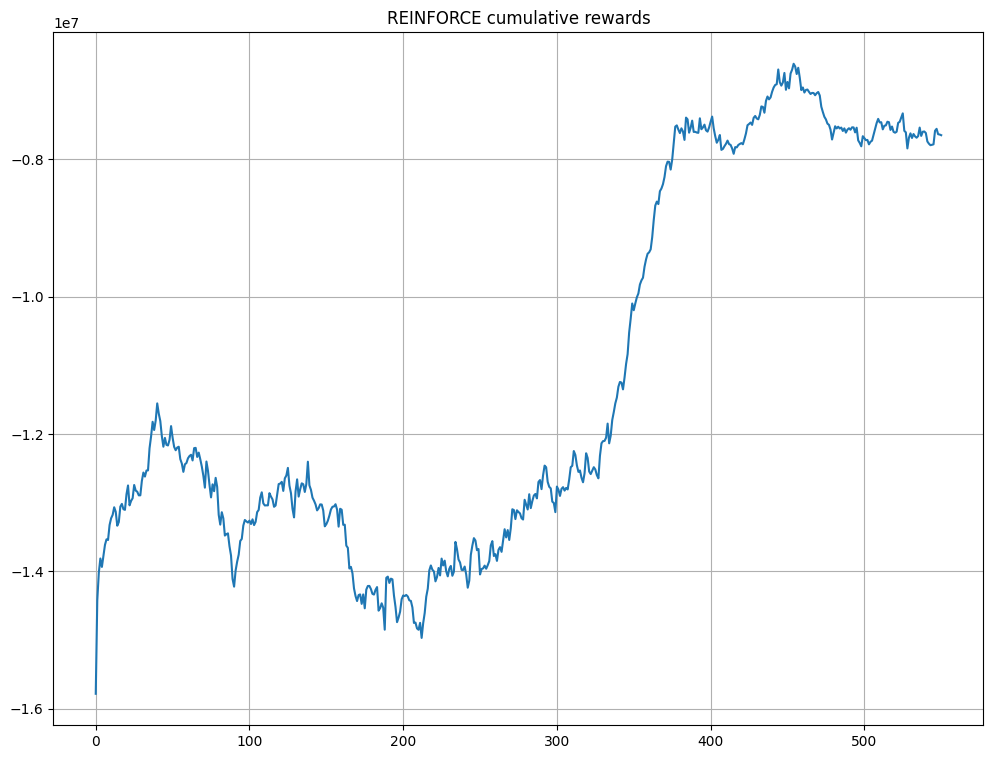

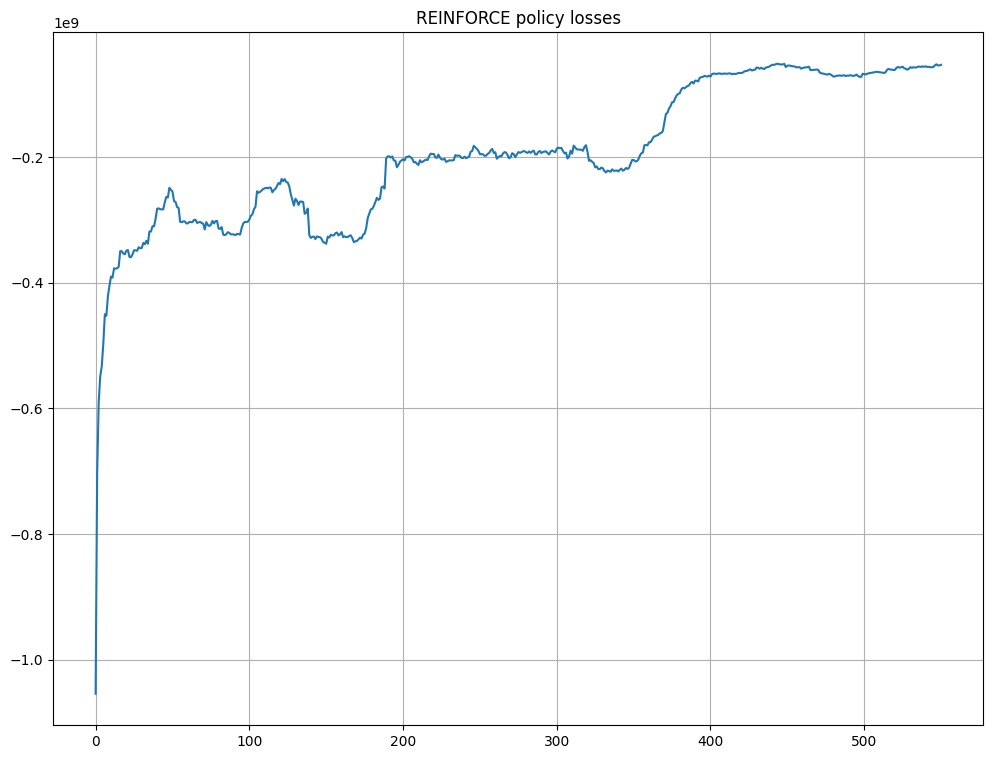

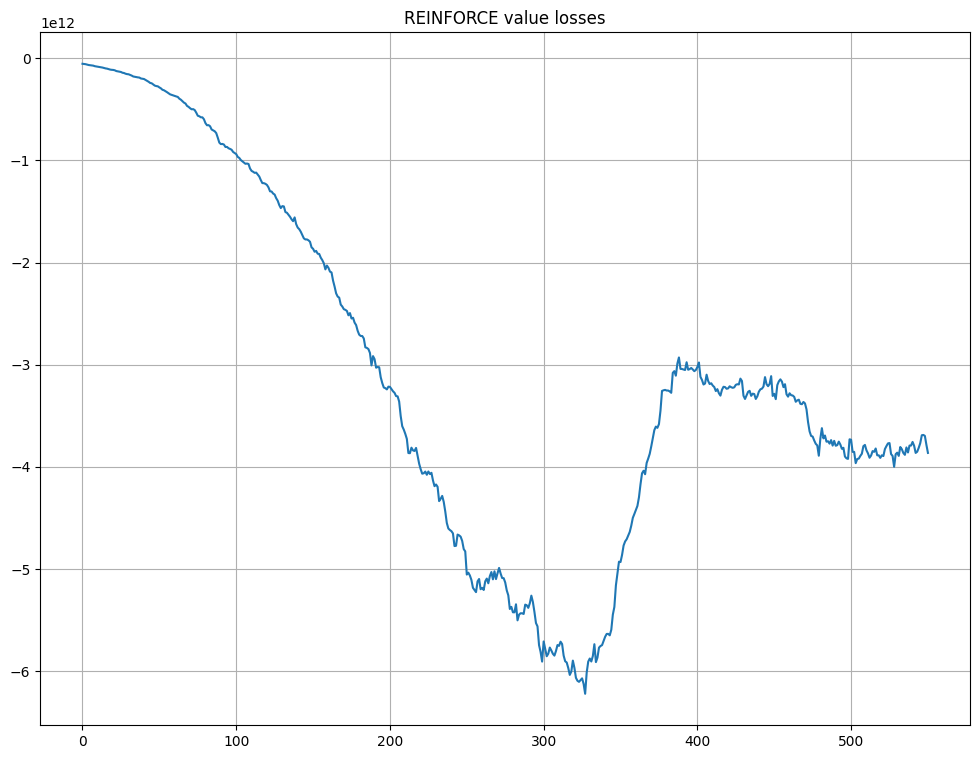

In [11]:
pgb = PolicyGradientWithBaseline()
pgb.train()
pgb.plot_rewards_and_losses()

Average reward: -7348775.94371955


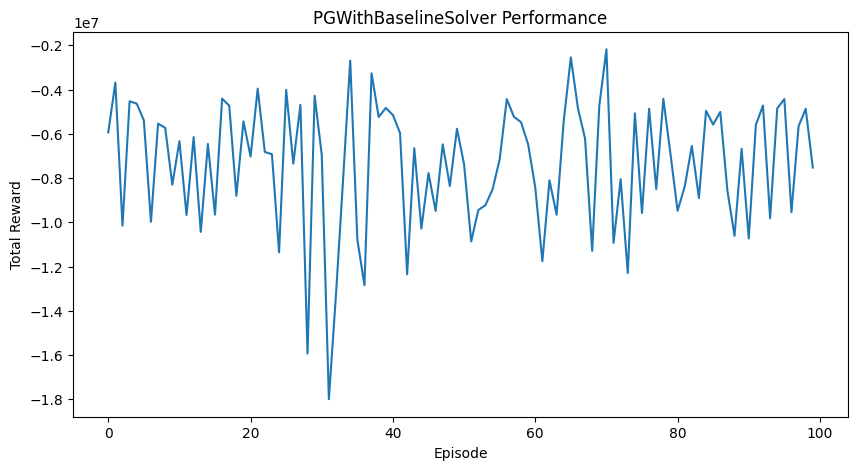

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt

class PGWithBaselineSolver():
    def __init__(self, env: gym.Env, model):
        self.env = env
        self.model = model

    def reset(self):
        pass

    def get_next_action(self, obs):
        return self.model.get_next_action(obs)


    def run_episode(self, max_steps=100):
        obs, info = self.env.reset()
        self.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = self.get_next_action(obs)
            obs, reward, done, truncated, info = self.env.step(action_flatten_to_matrix(action, N, M))
            total_reward += reward
            if done or truncated:
                break
        # print(f"info[\"done\"]: {info['done']}")
        return total_reward

    def plot(self, rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('PGWithBaselineSolver Performance')
        plt.savefig("PGWithBaseline_performance.png")
        plt.show()



    def benchmark(self, num_episodes=100):
        rewards = []
        for _ in range(num_episodes):
            total_reward = self.run_episode(max_steps=100)
            rewards.append(total_reward)
        return rewards

if __name__ == "__main__":
    solver = PGWithBaselineSolver(env, pgb)
    rewards = solver.benchmark(num_episodes=100)
    print(f"Average reward: {sum(rewards) / len(rewards)}")
    solver.plot(rewards)

In [19]:
class ActorCriticOneStep(object):
  def __init__(self):
    self.policy = PolicyNetwork(n_inputs=N*M*5, n_outputs=(N+1)*M, hidden_dim_size=128).to(device)
    self.value = ValueNetwork(num_states=N*M*5, hidden_dim=128).to(device)
    self.policy_optimizer = torch.optim.Adam(params=self.policy.parameters(), lr=8e-5)
    self.value_optimizer = torch.optim.Adam(params=self.value.parameters(), lr=1e-3)

    self.rewards = []
    self.policy_losses = []
    self.value_losses = []

  def train(self, num_trajectories=500, max_episode_length=100, gamma=0.99):
    # iterating through trajectories
    for tau in tqdm(range(num_trajectories)):
        # resetting the environment
        state, info = env.reset(seed=123)
        # setting done to False for while loop
        done = False

        t = 0
        rewardSum = 0.0
        while done == False and t < max_episode_length:
            # retrieving π and logπ
            action_probs, action_log_probs = self.policy(torch.tensor(state).to(device).flatten())
            # print(f"action probs: {action_probs}")
            # retrieving value of the state we're currently in
            current_state_value = self.value(torch.tensor(state).to(device).flatten())
            # sampling the action according to the distribution given by π
            action_probs_np = action_probs.flatten().detach().cpu().numpy()
            action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
            # print(action, action_formatted)
            # keeping track of previous state
            prev_state = state
            # environment step
            state, reward, done, truncation, info = env.step(action_flatten_to_matrix(action, N, M))
            # getting the value of next state - no value if the state is terminal
            if done == False:
                next_state_value = self.value(torch.tensor(state).to(device).flatten())
            else:
                next_state_value = torch.tensor(0.).to(device)

            # delta computation
            reward = torch.tensor(reward).to(device)
            rewardSum += reward.detach().cpu()
            # detaching the next state gradients for the value function update
            delta = reward + gamma * next_state_value.detach() - current_state_value

            # value update
            self.value_optimizer.zero_grad()
            value_loss = delta ** 2
            self.value_losses.append(value_loss.item())
            value_loss.backward()
            self.value_optimizer.step()

            # policy update
            self.policy_optimizer.zero_grad()
            # detaching the delta time from policy computation graph
            policy_loss = - delta.detach() * action_log_probs[action]
            self.policy_losses.append(policy_loss.item())
            policy_loss.backward()
            self.policy_optimizer.step()

            t += 1
        self.rewards.append(rewardSum)

  def plot_rewards_and_losses(self):
    # plot the results of the training
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.rewards,100))
    plt.grid()
    plt.title("REINFORCE cumulative rewards")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.policy_losses,100))
    plt.grid()
    plt.title("REINFORCE policy losses")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.value_losses,100))
    plt.grid()
    plt.title("REINFORCE value losses")

  def get_next_action(self, obs):
    action_probs, _ = self.policy(torch.tensor(obs).to(device).flatten())
    action_probs_np = action_probs.flatten().detach().cpu().numpy()
    action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
    return action



100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


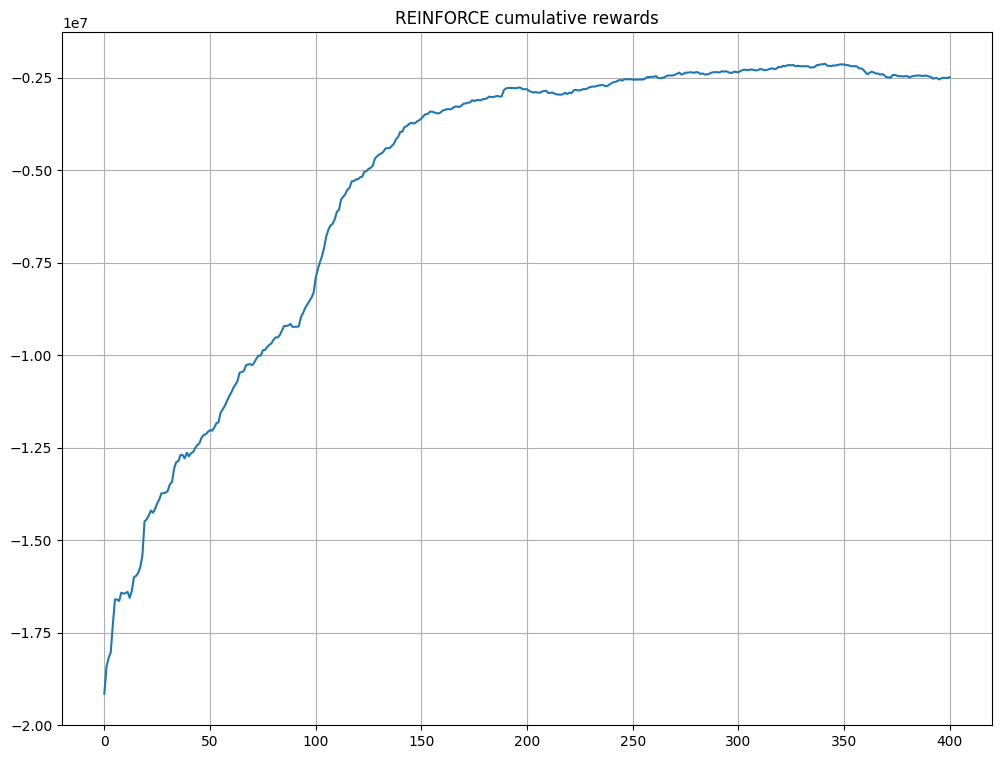

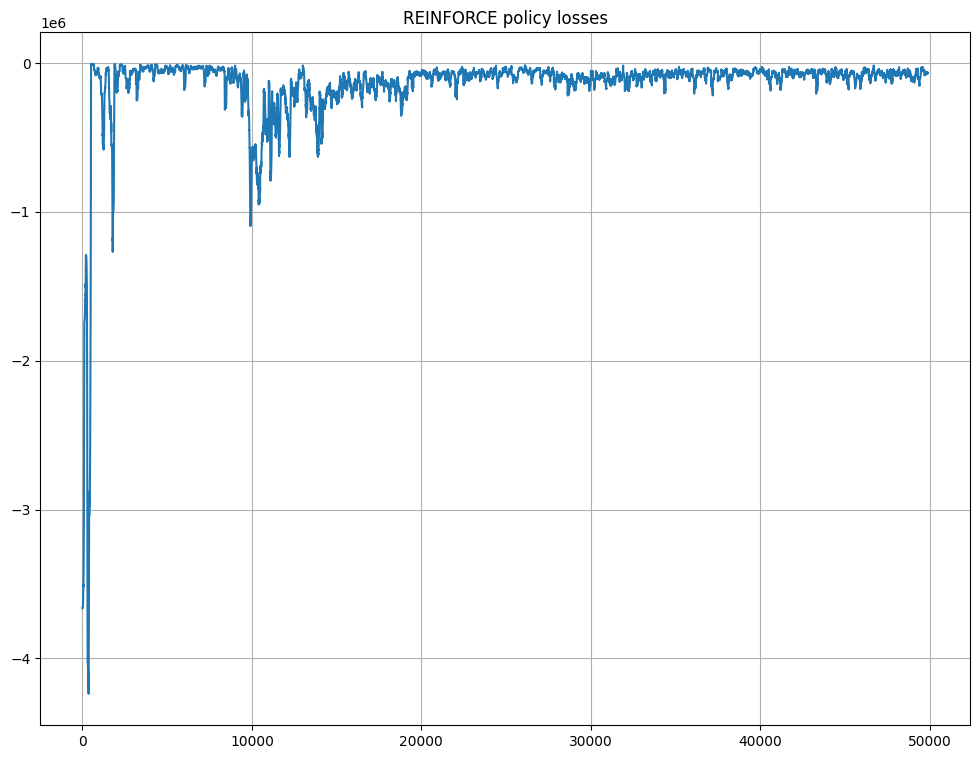

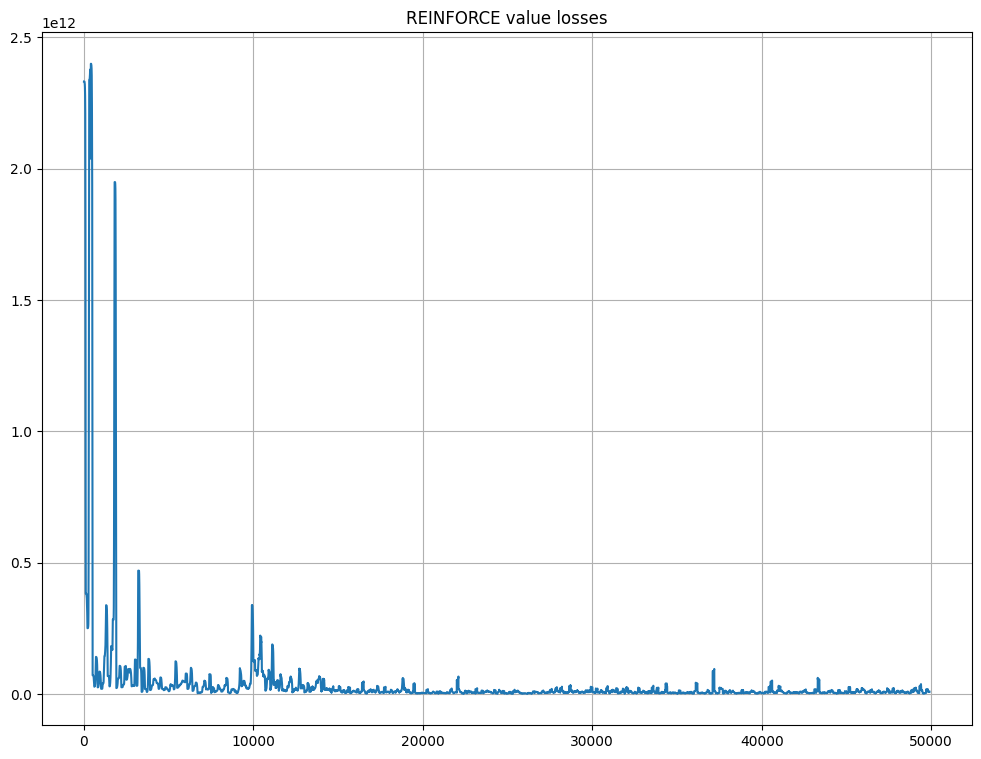

In [20]:
ac1 = ActorCriticOneStep()
ac1.train()
ac1.plot_rewards_and_losses()

Average reward: -2682482.605272057


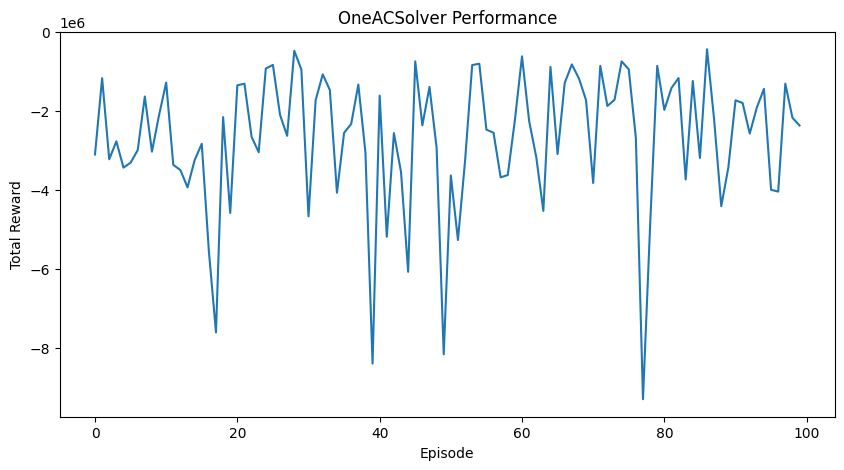

In [21]:
import gymnasium as gym
import matplotlib.pyplot as plt

class OneACSolver():
    def __init__(self, env: gym.Env, model):
        self.env = env
        self.model = model

    def reset(self):
        pass

    def get_next_action(self, obs):
        return self.model.get_next_action(obs)


    def run_episode(self, max_steps=100):
        obs, info = self.env.reset()
        self.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = self.get_next_action(obs)
            obs, reward, done, truncated, info = self.env.step(action_flatten_to_matrix(action, N, M))
            total_reward += reward
            if done or truncated:
                break
        # print(f"info[\"done\"]: {info['done']}")
        return total_reward

    def plot(self, rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('OneACSolver Performance')
        plt.savefig("OneAC_performance.png")
        plt.show()



    def benchmark(self, num_episodes=100):
        rewards = []
        for _ in range(num_episodes):
            total_reward = self.run_episode(max_steps=100)
            rewards.append(total_reward)
        return rewards

if __name__ == "__main__":
    solver = OneACSolver(env, ac1)
    rewards = solver.benchmark(num_episodes=100)
    print(f"Average reward: {sum(rewards) / len(rewards)}")
    solver.plot(rewards)